# Analyse planetary nebual
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : 16 September2021
- **kernel : anaconda3_auxtel**
- update : July 22th 2021
- update : September 16th 2021 



# Selection Flag

In [297]:
from astropy.io import fits
import sys, platform, os
#from astropy.visualization import simple_norm
#from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch
import astropy.visualization  as aspv
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from matplotlib.colors import LogNorm

In [298]:
import matplotlib.transforms as mtransforms

In [299]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord

In [300]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,12)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Initialisation

## Units

In [301]:
m_to_mm=1000.
mm_to_m=1e-3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
mm_to_micr=1e3
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm
nm_to_micr=0.001

In [302]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [303]:
deg_to_rad=np.pi/180.

In [304]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Site

In [305]:
FLAG_CC=False
FLAG_LOCAL=True

## Disperser

In [306]:
#DISPERSER_SEL="holo4_003"
DISPERSER_SEL="ronchi170lpmm"

In [307]:
if DISPERSER_SEL=="holo4_003":
    a=1/150.*mm_to_micr
else:
    a=1/170.*mm_to_micr
        

## Input Dir

In [308]:
if FLAG_CC:
#intputdir_day_1="/sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-07/" 
    if DISPERSER_SEL=="holo4_003":
        intputdir="/sps/lsst/groups/auxtel/data/2021/holo/quickLookExp/2021-09-09/"
    else:
        inputdir="/sps/lsst/groups/auxtel/data/2021/ronchi170lpmm/quickLookExp/2021-09-09"
if FLAG_LOCAL:
    if DISPERSER_SEL=="holo4_003":
        intputdir="/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-09-09"
    else:
        intputdir="/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp/2021-09-09"

## Telescope and CCD

In [309]:
Tel_Focal_Length=20.6 # m : Focal length of the telescope
Tel_Diameter=1.2 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
plt_scale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [310]:
Det_xpic=10.0 # microns per pixel
Det_NbPix=4096 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

In [311]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Dispersion function

In [312]:
def Dispersion(wl,a,D):
    """
    - input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    all have the same unit
    """
    X=D/a*wl/np.sqrt(1-(wl/a)**2)
    return X

In [313]:
def Dispersion_Rate(wl,a,D):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in microns and lambdas in microns
    
    """
    dxdlambda=D/a*(np.sqrt(1-(wl/a)**2)+ (wl/a)**2)/(1-(wl/a)**2)
    return dxdlambda 

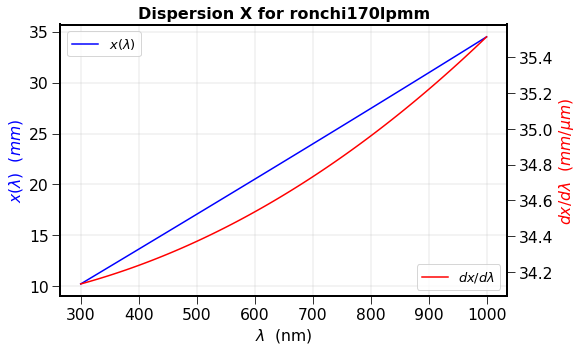

In [314]:
fig, ax1 = plt.subplots(figsize=(8,5))
WL=np.linspace(300.,1000.,100)
#a=1/150.*mm_to_micr
D=200*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)*micr_to_mm
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
title = "Dispersion X for {}".format(DISPERSER_SEL)
ax1.set_title(title)
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)*micr_to_mm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/\mu m$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

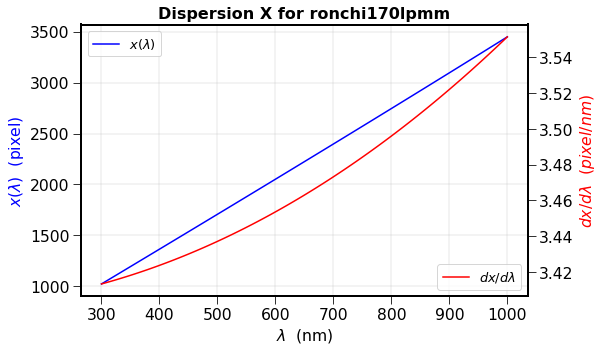

In [315]:
fig, ax1 = plt.subplots(figsize=(8,5))
WL=np.linspace(300.,1000.,100)
#a=1/150.*mm_to_micr
D=200*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
title = "Dispersion X for {}".format(DISPERSER_SEL)
ax1.set_title(title)
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)/Det_xpic*1e-3   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

# Pixel to wavelength

In [316]:
a

5.88235294117647

In [317]:
WL=np.linspace(-4000.,4000.,400)

In [318]:
Npix=Dispersion(WL*nm_to_micr,a,D)/Det_xpic   # pixel

In [319]:
dNpixdlambda=Dispersion_Rate(WL*nm_to_micr,a,D)/Det_xpic*1e-3   # pixel per nm

Text(0.5, 0.98, 'ronchi170lpmm')

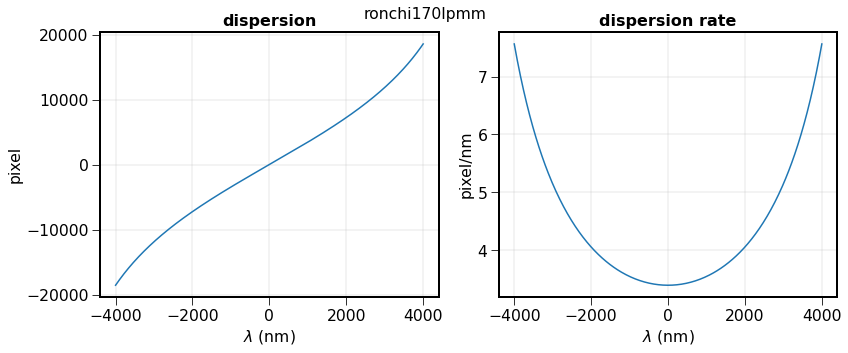

In [320]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(WL,Npix)
ax.grid()
ax.set_title("dispersion")
ax.set_ylabel("pixel")
ax.set_xlabel("$\lambda$ (nm)")

ax=fig.add_subplot(1,2,2)
ax.plot(WL,dNpixdlambda)
ax.grid()
ax.set_title("dispersion rate")
ax.set_ylabel("pixel/nm")
ax.set_xlabel("$\lambda$ (nm)")

plt.tight_layout()
title = "{}".format(DISPERSER_SEL)  
plt.suptitle(title)

## Interpolation

In [321]:
from scipy import interpolate

In [322]:
pixel_to_wavelength=interpolate.interp1d(Npix,WL)
dpixel_to_dwavelength=interpolate.interp1d(Npix,dNpixdlambda)

# Target

In [323]:
target_name="PNG321.0+03.9"

In [324]:
target_coord=SkyCoord.from_name(target_name)
target_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (224.97283918, -54.3020902)>

In [325]:
tagname=".*(PNG).*"

# Work

In [326]:
list_of_files=os.listdir(intputdir)    

In [327]:
print(list_of_files)

['ronchi170lpmm_empty_PNG321.0+03.9_20210909_000159_quickLookExp.fits', 'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000158_quickLookExp.fits', 'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000156_quickLookExp.fits', 'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000162_quickLookExp.fits', 'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000157_quickLookExp.fits', 'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000163_quickLookExp.fits', 'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000160_quickLookExp.fits', 'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000164_quickLookExp.fits', 'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000161_quickLookExp.fits']


In [328]:
bad_files = []
idx=0
for file in list_of_files:
    if re.search(".*(PNG).*",file):
        print(file)
    else:
        bad_files.append(idx)
        
    idx+=1
        

ronchi170lpmm_empty_PNG321.0+03.9_20210909_000159_quickLookExp.fits
ronchi170lpmm_empty_PNG321.0+03.9_20210909_000158_quickLookExp.fits
ronchi170lpmm_empty_PNG321.0+03.9_20210909_000156_quickLookExp.fits
ronchi170lpmm_empty_PNG321.0+03.9_20210909_000162_quickLookExp.fits
ronchi170lpmm_empty_PNG321.0+03.9_20210909_000157_quickLookExp.fits
ronchi170lpmm_empty_PNG321.0+03.9_20210909_000163_quickLookExp.fits
ronchi170lpmm_empty_PNG321.0+03.9_20210909_000160_quickLookExp.fits
ronchi170lpmm_empty_PNG321.0+03.9_20210909_000164_quickLookExp.fits
ronchi170lpmm_empty_PNG321.0+03.9_20210909_000161_quickLookExp.fits


In [329]:
#list_of_file=np.array(list_of_files)
list_of_files=np.delete(list_of_files,bad_files)

In [330]:
NB=len(list_of_files)

In [331]:
idx_file=0

In [332]:
fits_image_filename=list_of_files[idx_file]
full_fits_image_filename=os.path.join(intputdir,fits_image_filename)

In [333]:
fits_image_filename

'ronchi170lpmm_empty_PNG321.0+03.9_20210909_000159_quickLookExp.fits'

In [334]:
hdul = fits.open(full_fits_image_filename)

In [335]:
hdul.info()

Filename: /Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp/2021-09-09/ronchi170lpmm_empty_PNG321.0+03.9_20210909_000159_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [336]:
image=hdul[0].data
header=hdul[0].header

In [337]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-09-09T23:46:43.797'                                             
DATE-OBS= '2021-09-09T23:46:47.933'                                             
DATE-BEG= '2021-09-09T23:46:47.933'                                             
DATE-END= '2021-09-09T23:47:18.157'                                             
MJD     =     59466.9907846829                                                  
MJD-OBS =     59466.99083256

In [338]:
image.shape

(4000, 4072)

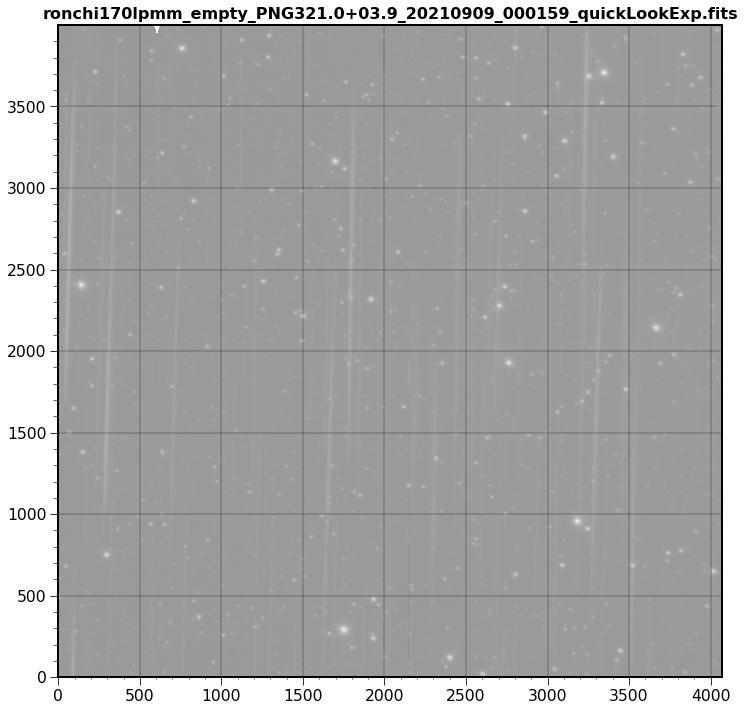

In [339]:
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(1,1,1)

ax.imshow(image,origin="lower",norm=LogNorm(),cmap="gray")

ax.minorticks_on()
ax.grid(color="k")
ax.set_title(fits_image_filename)
ax.grid(color="k")

# Spectrum

In [340]:
target_name="PNG321.0+03.9"

In [341]:
target_coord=SkyCoord.from_name(target_name)
target_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (224.97283918, -54.3020902)>

In [342]:
Xcenter=1760
Ycenter=300
dX=10

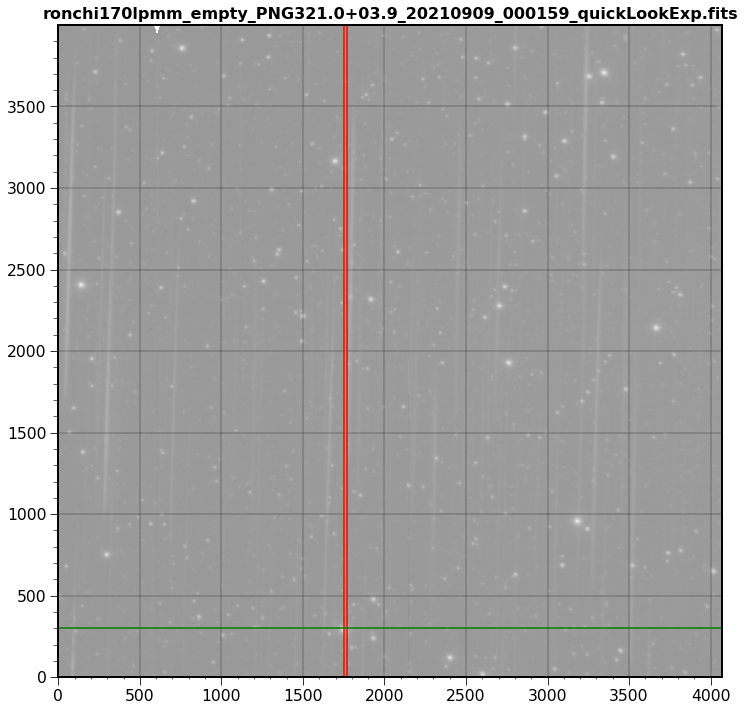

In [343]:
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(1,1,1)

ax.imshow(image,origin="lower",norm=LogNorm(),cmap="gray")

ax.minorticks_on()
ax.grid(color="k")
ax.set_title(fits_image_filename)
ax.axvline(x=Xcenter,color="y")
ax.axvline(x=Xcenter-dX,color="r")
ax.axvline(x=Xcenter+dX,color="r")

ax.axhline(y=Ycenter,color="g")

ax.grid(color="k")

In [344]:
spectrum=np.copy(image[:,Xcenter-dX:Xcenter+dX]).sum(axis=1)

In [345]:
spectrum_index=np.arange(spectrum.size)

In [346]:
spectrum_index-Ycenter

array([-300, -299, -298, ..., 3697, 3698, 3699])

In [347]:
wl= pixel_to_wavelength(spectrum_index-Ycenter)
dwlperdpixel=dpixel_to_dwavelength(spectrum_index-Ycenter) # number of pixels per nm

In [348]:
dwlperdpixel

array([3.4011528 , 3.40114585, 3.40113889, ..., 3.57378582, 3.57387898,
       3.57397214])

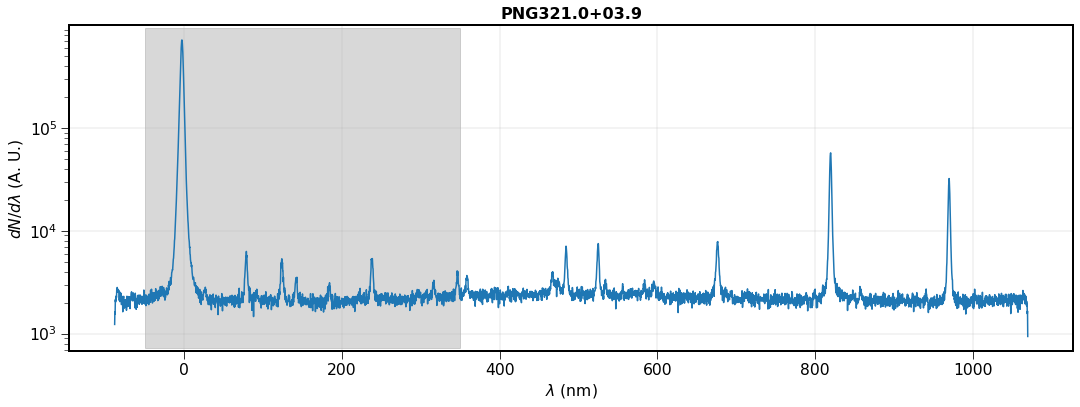

In [349]:
fig=plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,1,1)

#trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

y=spectrum*dwlperdpixel

ax.semilogy(wl,y)

ax.axvspan(-50, 350., ymin=0.01, ymax=0.99, alpha=0.3, color='gray')

#ax.fill_between(wl, y.min(), y.max() , where= wl < 350,facecolor='green', alpha=0.5, transform=trans)

ax.set_title(target_name)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("$dN/d\\lambda$ (A. U.)")
ax.grid()

In [350]:
wl

array([ -88.22523959,  -87.93120437,  -87.63716916, ..., 1069.23596304,
       1069.51580051, 1069.79563799])

## All spectra

In [351]:
all_images=[]
all_id=[]
all_expo=[]

idx=0
for file in list_of_files:
    full_fits_image_filename=os.path.join(intputdir,file)
    hdu = fits.open(full_fits_image_filename)
    image=hdu[0].data
    header=hdu[0].header
    all_id.append(header['SEQNUM'])
    all_expo.append(header['EXPTIME'])
    all_images.append(image)
    idx+=1
    

In [352]:
all_id=np.array(all_id)
all_expo=np.array(all_expo)

In [353]:
all_id

array([159, 158, 156, 162, 157, 163, 160, 164, 161])

In [354]:
sorted_index=np.argsort(all_id)
sorted_index

array([2, 4, 1, 0, 6, 8, 3, 5, 7])

In [355]:
for idx in np.arange(NB):
    the_index=sorted_index[idx]
    print(all_id[the_index])

156
157
158
159
160
161
162
163
164


Text(0.5, 0, 'duration (s)')

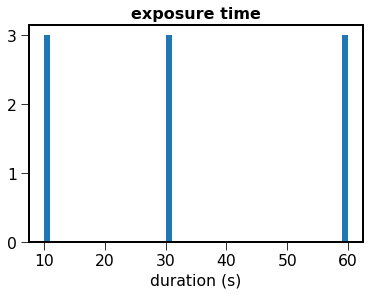

In [356]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(all_expo,bins=50)
ax.set_title("exposure time")
ax.set_xlabel("duration (s)")

In [357]:
NB=len(all_id)

In [358]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [359]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NB)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NB), alpha=1)

## Spectrum 1

(-400.0, 1200.0)

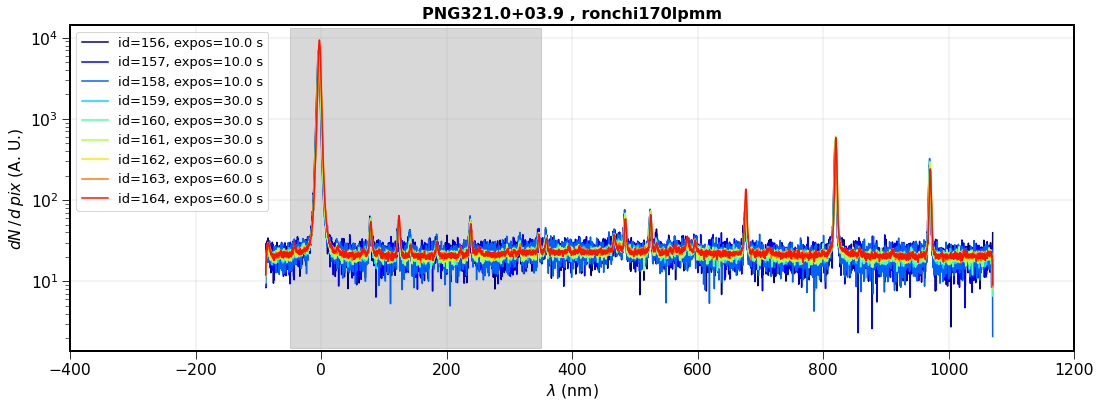

In [360]:
fig=plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,1,1)

for idx in np.arange(NB):
    the_index=sorted_index[idx]
    the_image=all_images[the_index]
    spectrum=np.copy(the_image[:,Xcenter-dX:Xcenter+dX]).sum(axis=1)
    spectrum_index=np.arange(spectrum.size)
    wl= pixel_to_wavelength(spectrum_index-Ycenter)
    
    
    
    label="id={}, expos={} s".format(all_id[the_index],all_expo[the_index])
    if all_expo[the_index]>5:
        ax.semilogy(wl,spectrum/all_expo[the_index],label=label,color=all_colors[idx])
    
title  = "{} , {}".format(target_name,DISPERSER_SEL)  
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("$dN\,/\,d\,pix$ (A. U.)")

ax.axvspan(-50, 350., ymin=0.01, ymax=0.99, alpha=0.3, color='gray')

ax.legend(loc="upper left")
ax.grid()
ax.set_xlim(-400,1200)

## Spectrum 2

(-400.0, 1200.0)

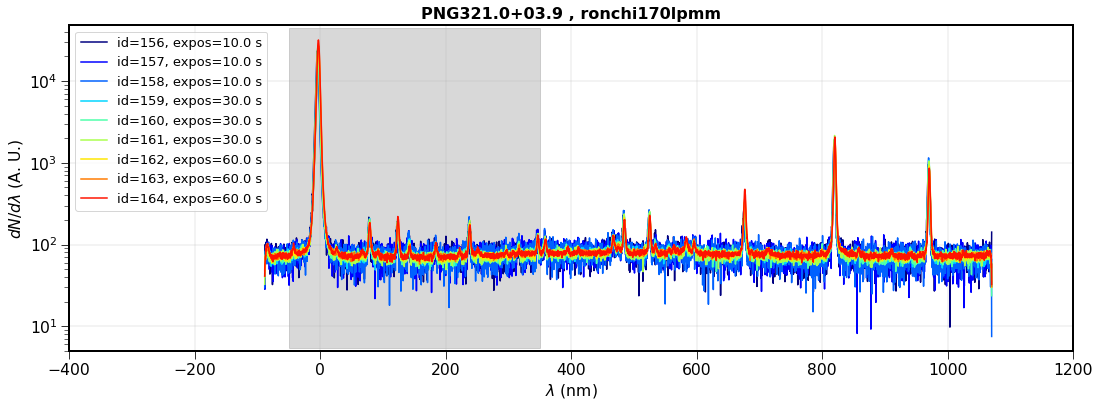

In [361]:
fig=plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,1,1)

for idx in np.arange(NB):
    the_index=sorted_index[idx]
    the_image=all_images[the_index]
    spectrum=np.copy(the_image[:,Xcenter-dX:Xcenter+dX]).sum(axis=1)
    spectrum_index=np.arange(spectrum.size)
    wl= pixel_to_wavelength(spectrum_index-Ycenter)
    dwlperdpixel=dpixel_to_dwavelength(spectrum_index-Ycenter) # number of pixels per nm
    
    
    label="id={}, expos={} s".format(all_id[the_index],all_expo[the_index])
    if all_expo[the_index]>5:
        ax.semilogy(wl,spectrum*dwlperdpixel/all_expo[the_index],label=label,color=all_colors[idx])
    
title  = "{} , {}".format(target_name,DISPERSER_SEL)  
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("$dN/d\\lambda$ (A. U.)")
ax.axvspan(-50, 350., ymin=0.01, ymax=0.99, alpha=0.3, color='gray')

ax.legend(loc="upper left")
ax.grid()
ax.set_xlim(-400,1200)
    
    

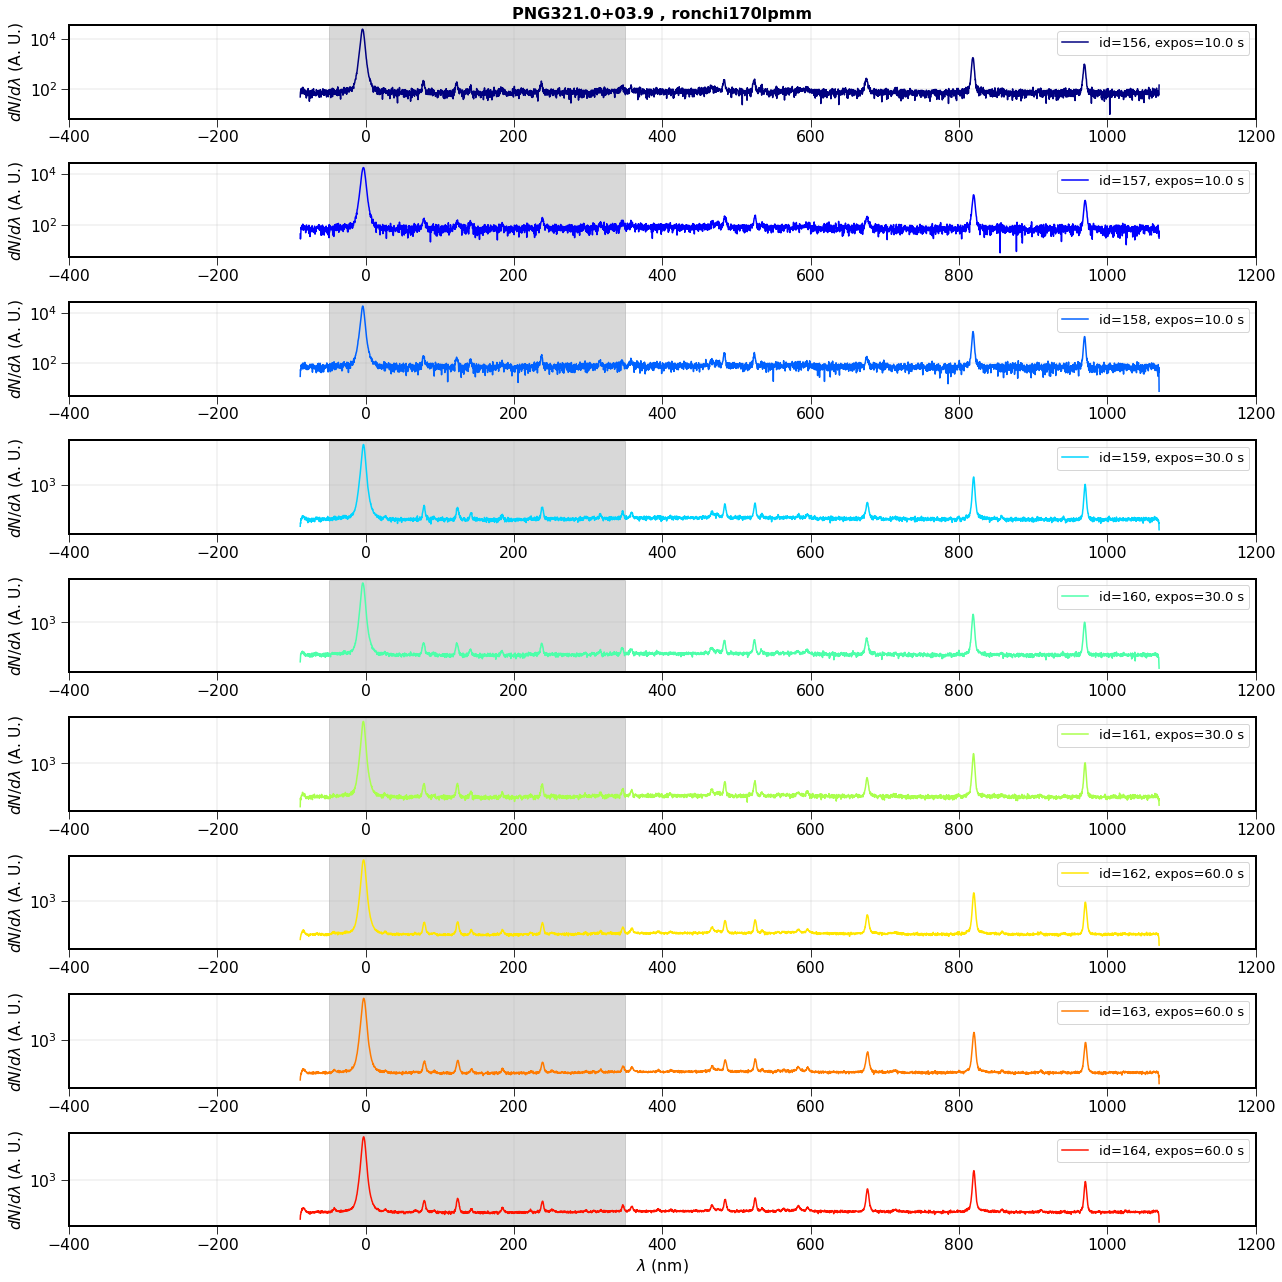

In [362]:
fig=plt.figure(figsize=(18,18))


for idx in np.arange(NB):
    ax=fig.add_subplot(NB,1,idx+1)
    the_index=sorted_index[idx]
    the_image=all_images[the_index]
    spectrum=np.copy(the_image[:,Xcenter-dX:Xcenter+dX]).sum(axis=1)
    spectrum_index=np.arange(spectrum.size)
    wl= pixel_to_wavelength(spectrum_index-Ycenter)
    dwlperdpixel=dpixel_to_dwavelength(spectrum_index-Ycenter) # number of pixels per nm
    label="id={}, expos={} s".format(all_id[the_index],all_expo[the_index])
    
    
    if all_expo[the_index]>5:
        ax.semilogy(wl,spectrum*dwlperdpixel/all_expo[the_index],label=label,color=all_colors[idx])
        ax.set_ylabel("$dN/d\\lambda$ (A. U.)")
        
        ax.axvspan(-50, 350., ymin=0.01, ymax=0.99, alpha=0.3, color='gray')
    
    if idx==0:
        title = title = "{} , {}".format(target_name,DISPERSER_SEL) 
        ax.set_title(title)
    if idx==NB-1:
        ax.set_xlabel("$\lambda$ (nm)")
    ax.legend()
    ax.grid()
    ax.set_xlim(-400,1200)
fig.tight_layout()

# study the range in dX

In [363]:
all_dX=np.arange(5,100,25)

In [364]:
all_dX

array([ 5, 30, 55, 80])

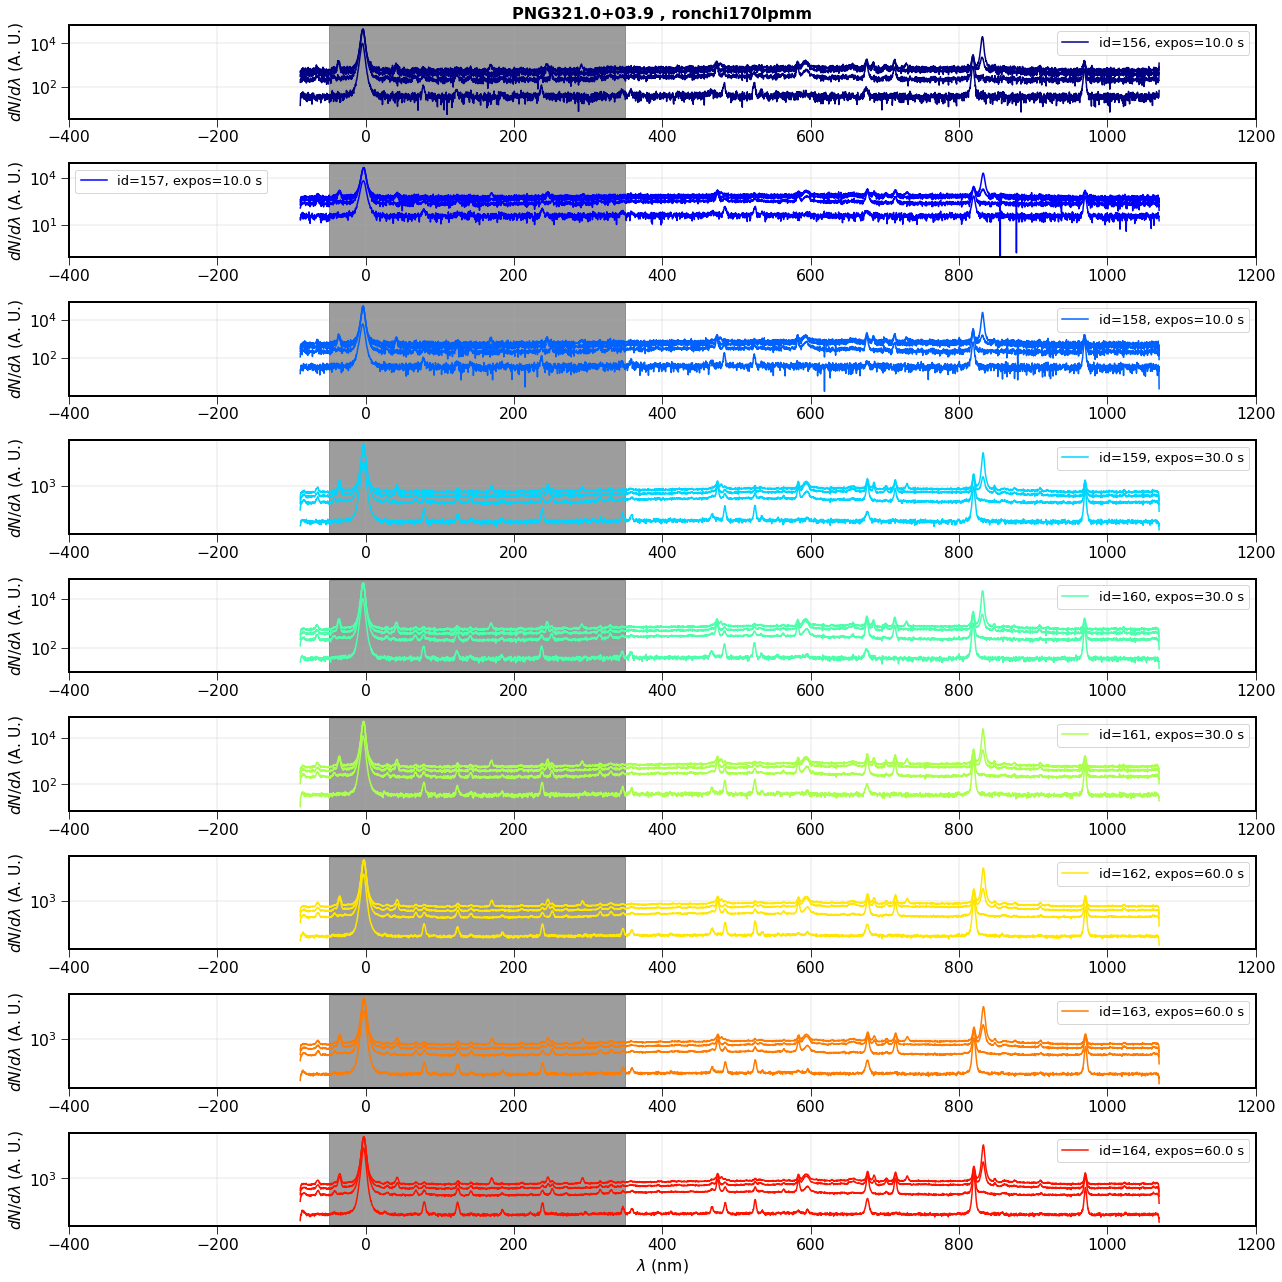

In [365]:
fig=plt.figure(figsize=(18,18))


for idx in np.arange(NB):
    ax=fig.add_subplot(NB,1,idx+1)
    the_index=sorted_index[idx]
    the_image=all_images[the_index]
    
    id2=0
    for the_dX in all_dX:
    
        spectrum=np.copy(the_image[:,Xcenter-the_dX:Xcenter+the_dX]).sum(axis=1)
        spectrum_index=np.arange(spectrum.size)
        wl= pixel_to_wavelength(spectrum_index-Ycenter)
        dwlperdpixel=dpixel_to_dwavelength(spectrum_index-Ycenter) # number of pixels per nm
        
        label="id={}, expos={} s".format(all_id[the_index],all_expo[the_index])
        if all_expo[the_index]>5:
            if id2==0:
                ax.semilogy(wl,spectrum*dwlperdpixel/all_expo[the_index],label=label,color=all_colors[idx])
                ax.set_ylabel("$dN/d\\lambda$ (A. U.)")
            else:
                ax.semilogy(wl,spectrum*dwlperdpixel/all_expo[the_index],color=all_colors[idx])
                
            ax.set_xlim(-400,1200)
            ax.axvspan(-50, 350., ymin=0.01, ymax=0.99, alpha=0.3, color='gray')
            
        id2+=1
        
        
    if idx==0:
        title = title = "{} , {}".format(target_name,DISPERSER_SEL) 
        ax.set_title(title)
    if idx==NB-1:
        ax.set_xlabel("$\lambda$ (nm)")
    ax.legend()
    ax.grid()
fig.tight_layout()